# Instructions
- From the __File__ menu, __Save a copy in Drive__. otherwise you will not be able to edit it

---
- From the __Runtime__ menu,  click on __Change runtime type__ . Here in __Hardware accelerator__ choose __GPU__ and __SAVE__

---
- To run a __Single Cell__ __ctrl + enter__
- To run  __all cells:ctrl + F9__
- To run  __all cells after:ctrl + F10__
- To run  __all cells before:ctrl + F8__
---

- run the __cell below__  (with the line __pip install -I --no-cache-dir pillow__). Go to __Runtime__ menu and __Restart runtime__
- After restarting, you can run all the cells

In [2]:
PLATFORM = 'colab'
if PLATFORM == 'colab':
    !pip install -I --no-cache-dir pillow

     |████████████████████████████████| 2.1MB 2.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [1]:
PLATFORM = 'colab'
if PLATFORM == 'colab':
    !git clone https://github.com/tumble-weed/suriya-self-supervised.git
    !mv suriya-self-supervised/*.py .
    !rm -rf suriya-self-supervised
    !wget -nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_" -O part_labels.zip && rm -rf /tmp/cookies.txt
    !unzip -o part_labels.zip
    
    DATA_ROOT = './'
elif PLATFORM == 'cosmos':
    DATA_ROOT = './'

Cloning into 'suriya-self-supervised'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
--2019-07-11 10:38:48--  https://docs.google.com/uc?export=download&confirm=yqts&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_
Resolving docs.google.com (docs.google.com)... 172.217.193.100, 172.217.193.138, 172.217.193.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.193.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/auqacd0l9tu3evgv7kr0iqt8nbov4dbr/1562839200000/10570413806168058073/*/1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_?e=download [following]
--2019-07-11 10:38:48--  https://doc-04-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/auqacd0l9tu3evgv7kr0i

# Context Encoders: Feature Learning by Inpainting
### Deepak Pathak, Phillip Krähenbühl, Jeff Donahue, Trevor Darrell, and Alexei A. Efros.
### CVPR, 2016
<a href="http://people.eecs.berkeley.edu/~pathak/papers/cvpr16.pdf">[Paper]</a>

<img src="http://people.eecs.berkeley.edu/~pathak/context_encoder/resources/teaser.jpg" width="400"/> <br/>
Given an image with a missing region (a), a human artist has no trouble inpainting it (b). Automatic inpainting using our context encoder trained with L2 reconstruction loss is shown in (c), and using both L2 and adversarial losses in (d).

A CNN (encoder-decoder network) is trained to generate the contents of an arbitrary image region conditioned on its surroundings. In order to succeed at this task, the model needs to both understand the content of the entire image, as well as produce a plausible hypothesis for the missing part(s).

As also seen in previous notebook, the (self-) supervision in the form of semantic inpainting is obtained with no cost and is very effective in learning useful representations.

We will use 5,000 images for pre-training the network for semantic inpainting task and later use this pre-trained model for face parsing.

In [0]:

import os.path as osp

import numpy as np
import cv2
import torch
from torch.utils import data
from random import shuffle
import os.path
import os
import copy
import math

In [0]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# from torch.autograd import Variable
import torch.nn as nn

### import other stuff
from enc_dec import encoder_decoder
from utils import *
# from inpaint_utils import *
import matplotlib.pyplot as plt


In [0]:
class ContextInpaintingDataset(data.Dataset):
    
    def __init__(self, img_root, image_list, mirror = True, 
        context_shape = [32, 32], context_count = 4, split = 'train'):

        self.img_root = img_root
        self.split = split
        self.image_list = [line.rstrip('\n') for line in open(image_list)]

        self.mirror = mirror
        self.context_shape = context_shape
        self.context_count = context_count

        self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434]) # because we are reading using cv2
        self.std_bgr = 255*np.array([0.229, 0.224, 0.225])


        self.files = {}
        if self.split not in self.files.keys():
            self.files[self.split] = []
        for f in self.image_list:

            self.files[self.split].append({'img': img_root+f, 'lbl': 0})
        
    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        image_file_name = self.img_root + self.image_list[index]
        
        image = None
        if os.path.isfile(image_file_name):
            image = cv2.imread(image_file_name)
        else:
            print('ERROR: couldn\'t find image -> ', image_file_name)
            
        if self.mirror: # randomly flip the image
            flip = torch.LongTensor(1).random_(0, 2)[0]*2-1 # complicated way of either -1, 1
            image = image[:, ::flip, :]

        ''' '''
        context_shape = self.context_shape
        context_mask = np.zeros((3, image.shape[0], image.shape[1]), np.uint8)

        ''' '''
        if self.context_count == 1:
            left = image.shape[0]/2 - context_shape[0]/2 #left of center patch
            context_mask[:, left:left+context_shape[0], left:left+context_shape[1]] = 1 # mask is made up ones
            image[left:left+context_shape[0], left:left+context_shape[1], 0] = self.mean_bgr[0] # put in mean values in this center
            image[left:left+context_shape[0], left:left+context_shape[1], 1] = self.mean_bgr[1] # put in mean values in this center
            image[left:left+context_shape[0], left:left+context_shape[1], 2] = self.mean_bgr[2] # put in mean values in this center

        else:
            orig_image = copy.deepcopy(image)
            for c_ in range(self.context_count):
                row = torch.LongTensor(1).random_(0, image.shape[0]-context_shape[0]-1)[0] # all valid locations for the left corner
                col = torch.LongTensor(1).random_(0, image.shape[1]-context_shape[1]-1)[0] # all valid locations for the left corner
                context_mask[:, row:row+context_shape[0], col:col+context_shape[1]] = 1
                image[row:row+context_shape[0], col:col+context_shape[1], 0] = self.mean_bgr[0]
                image[row:row+context_shape[0], col:col+context_shape[1], 1] = self.mean_bgr[1]
                image[row:row+context_shape[0], col:col+context_shape[1], 2] = self.mean_bgr[2]


        return self.transform_image(image), self.transform_mask(context_mask), self.transform_context(orig_image)

    def transform_image(self, image):
        # normalize the image by subtracting mean
        # why no need to divide by deviation?
        image = image.astype(np.float64)
        image -= self.mean_bgr
        image = image.transpose(2, 0, 1) # torch tensors are (batch,channel,row,col)
        image = torch.from_numpy(image.copy()).float() 

        return image

    def transform_mask(self, mask):
        
        mask = torch.from_numpy(mask.copy()).float() # convert to tensor

        return mask

    def transform_context(self, context):
        # normalize the context by subtracting mean
        # divide standard deviation
        
        context = context.astype(np.float64)
        context -= self.mean_bgr
        context[:,:,0] /= 3*self.std_bgr[0]
        context[:,:,1] /= 3*self.std_bgr[1]
        context[:,:,2] /= 3*self.std_bgr[2]


        context[context>1] = 1 # limit values to -1 to 1
        context[context<-1] = -1

        context = context.transpose(2, 0, 1) 
        context = torch.from_numpy(context.copy()).float()

        return context        

In [0]:
### define dataset paths
# what is the split of LFW?
train_img_root = DATA_ROOT + 'part_labels/data/all/'
train_image_list = DATA_ROOT + 'part_labels/splits/train_unlabeled_5k.txt'

val_img_root = DATA_ROOT + 'part_labels/data/all/'
val_image_list = DATA_ROOT + 'part_labels/splits/val_unlabeled_500.txt'

You can change the amount and size of regions to be erased by passing argument to the data loader. Default is context_shape = [32, 32], context_count = 4

In [0]:
train_loader = torch.utils.data.DataLoader(ContextInpaintingDataset(img_root = train_img_root,
                                                                  image_list = train_image_list, mirror = True),
                                           batch_size=16, num_workers=2, shuffle = True, pin_memory=False)

val_loader = torch.utils.data.DataLoader(ContextInpaintingDataset(img_root = val_img_root,
                                                                  image_list = val_image_list, mirror = True,split='val'),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

We define an encoder-decoder architecture with 4 convolution layers each. Each convolution layer (except the last layer) is followed by BatchNorm and ReLU (not shown in figure). We will use context inpainting technique to pre-train the encoder as well as the decoder in self-supervised way and later use it for face parsing in 3rd notebook.

<img src="https://docs.google.com/drawings/d/e/2PACX-1vS_yenRY55ol0M6k3aJTh6yVVSYEgcCmqQEFWtkBeCg2tXOtMLTntjWZgwtrGy4xFitUVs3n-W6Ss5Y/pub?w=2373&h=442" width=1400>

In [0]:
net = encoder_decoder().cuda()
tanh = nn.Tanh() # to make the output within (-1 to 1)
experiment = 'self_supervised_pre_train_semantic_inpainting'

In [8]:
print('Net params count (M): ', param_counts(net)/(1000000.0))

Net params count (M):  0.121251


In [0]:
use_cuda = torch.cuda.is_available()
best_loss = 9999  # best test accuracy

In [10]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [30,40], gamma=0.1, last_epoch=-1) # learning rate starts from 0.1, 0.01 from 30, 0.001 from 40
trends = {'train_loss':[],
         'val_loss':[]}
for epoch in range(0, 50):
    
    '''
    Train
    '''
    
    print('\nTrain epoch: %d' % epoch)
    net.train()
    train_loss = 0
    for batch_idx, (inputs, masks, contexts) in enumerate(train_loader):
        if use_cuda:
            inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
        optimizer.zero_grad()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
        outputs = tanh(net(inputs))
        
        # no adversarial loss
        # look closely at the masked regions
        # and less importance is given to the rest of the image (to keep the results smooth)
        loss = 0.99*torch.mean(torch.mul((outputs - contexts)**2, masks)) + 0.01*torch.mean(torch.mul((outputs - contexts)**2, 1-masks))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
   
    train_loss = (train_loss/(batch_idx+1))
    print('Loss: %f '% train_loss)
    
    '''
    Val
    '''
    print('\nVal epoch: %d' % epoch)
    net.eval()
    val_loss = 0
    for batch_idx, (inputs, masks, contexts) in enumerate(val_loader):
        if use_cuda:
            inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
        outputs = tanh(net(inputs))
        loss = 0.99*torch.mean(torch.mul((outputs - contexts)**2, masks)) + 0.01*torch.mean(torch.mul((outputs - contexts)**2, 1-masks))
        val_loss += loss.item()
    val_loss = (val_loss/(batch_idx+1))
    print('Loss: %f '% val_loss)
    # Save checkpoint.
    if val_loss < best_loss:
        print('Saving..')
        state = {'net': net}
        if not os.path.isdir(DATA_ROOT + 'checkpoint'):
            os.mkdir(DATA_ROOT + 'checkpoint')
        torch.save(state, DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')
        best_loss = val_loss
    trends['train_loss'].append(train_loss)
    trends['val_loss'].append(val_loss)
    '''
    lr scheduler step
    '''
    lr_scheduler.step()


Train epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss: 0.006948 

Val epoch: 0
Loss: 0.004020 
Saving..

Train epoch: 1
Loss: 0.004084 

Val epoch: 1
Loss: 0.003579 
Saving..

Train epoch: 2
Loss: 0.003622 

Val epoch: 2
Loss: 0.003381 
Saving..

Train epoch: 3
Loss: 0.003412 

Val epoch: 3
Loss: 0.003250 
Saving..

Train epoch: 4
Loss: 0.003249 

Val epoch: 4
Loss: 0.002970 
Saving..

Train epoch: 5
Loss: 0.003040 

Val epoch: 5
Loss: 0.002860 
Saving..

Train epoch: 6
Loss: 0.002993 

Val epoch: 6
Loss: 0.002995 

Train epoch: 7
Loss: 0.002795 

Val epoch: 7
Loss: 0.002502 
Saving..

Train epoch: 8
Loss: 0.002796 

Val epoch: 8
Loss: 0.002782 

Train epoch: 9
Loss: 0.002671 

Val epoch: 9
Loss: 0.002571 

Train epoch: 10
Loss: 0.002581 

Val epoch: 10
Loss: 0.002528 

Train epoch: 11
Loss: 0.002514 

Val epoch: 11
Loss: 0.002434 
Saving..

Train epoch: 12
Loss: 0.002432 

Val epoch: 12
Loss: 0.002387 
Saving..

Train epoch: 13
Loss: 0.002360 

Val epoch: 13
Loss: 0.002123 
Saving..

Train epoch: 14
Loss: 0.002280 

Val epoch: 14
Lo

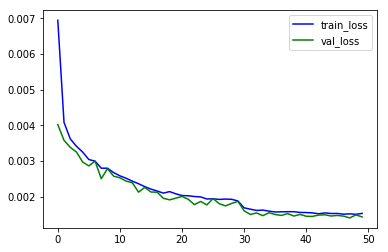

In [11]:
plt.figure()
plt.plot(trends['train_loss'],color='b',label='train_loss')
plt.plot(trends['val_loss'],color='g',label='val_loss')
plt.legend()
plt.show()

In [12]:
iter_val_loader = iter(val_loader)
inputs, masks, contexts = next(iter_val_loader)
if use_cuda:
    inputs, masks, contexts = inputs.cuda(), masks.cuda(), contexts.cuda()
#         inputs = Variable(inputs)
#         masks = Variable(masks)
#         contexts = Variable(contexts)
outputs = tanh(net(inputs))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


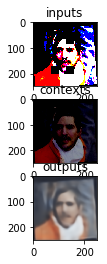

In [13]:
# inputs = inputs.detach().cpu().numpy()
# input_im = np.transpose(inputs[0],(1,2,0))
# input_im = (input_im + 1)/2.

# contexts = contexts.detach().cpu().numpy()
# context_im = np.transpose(contexts[0],(1,2,0))
# # output_im = (output_im + 1)/2.


# outputs = outputs.detach().cpu().numpy()
# output_im = np.transpose(outputs[0],(1,2,0))
# output_im = (output_im + 1)/2.

# context_im = context_im[:,:,::-1]
# input_im = input_im[:,:,::-1]
# output_im = output_im[:,:,::-1]
# f,ax = plt.subplots(3)
# ax[0].imshow(input_im)
# ax[0].title.set_text('input')

# ax[1].imshow(context_im)
# ax[1].title.set_text('context')

# ax[2].imshow(output_im)
# ax[2].title.set_text('output')

# plt.show()

f,ax = plt.subplots(3)
for i,(t,n) in enumerate(zip([inputs,contexts,outputs],['inputs','contexts','outputs'])):
    im = t.detach().cpu().numpy()[0]
    im = np.transpose(im,(1,2,0))
    if n == 'outputs':
        im = (im+1)/2.
    else:
        mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])/255. # because we are reading using cv2
        std_bgr = np.array([0.229, 0.224, 0.225])
        
        im = im * 3*std_bgr[None,None,:]
        
    im = im[:,:,::-1]

    ax[i].imshow(im)
    ax[i].title.set_text(n)
plt.show()
    




In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
output_im.shape

NameError: ignored